##### SME0202 Métodos Numéricos em Equações Diferenciais Ordinárias
## Trabalho 3 - Equações Parabólicas e Hiperbólicas
- Cody Stefano Barham Setti - 4856322
- Ian de Holanda Cavalcanti Bezerra - 13835412

#### 0.1 - Bibliotecas Usadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1 - Resolução das Tarefas 1 e 2.(a) - Gráficos 3D da Eq. de Advecção-Difusão

A equação de advecção-difusão que devemos resolver é:
$$
\left\{\begin{aligned}
    &u_t(x,t) + u_x(x,t) = \frac{1}{\mathbb{P}e}u_{xx}(x,t) \\
    &u(x+15,t) = u(x,t) \qquad &&(\text{condição de contorno}) \\
    &u(x,0) = \exp(-20(x-2)^2) + \exp(-(x-5)^2) \qquad &&(\text{valor inicial})
\end{aligned}\right.
$$
Analisaremos o problema no intervalo de tempo $T=[0,12)$. Logo, em código:

In [2]:
L = 15.0  # Comprimento do domínio espacial
T = 12.0  # Período temporal de estudo

def initial_value(x):
    return np.exp(-20*(x-2)**2) + np.exp(-(x-5)**2)

#### 1.1 - Determinação do Algoritmo FTCS ('*Forward Time, Centered Space*')

Portanto, se discretizarmos a equação aplicando diferenças progressivas no tempo e centradas no espaço, teremos:
$$
    \frac{U^{n+1}_j-U^n_j}{\Delta n} + \frac{U^n_{j+1}-U^n_{j-1}}{2\Delta x} = \frac{1}{\mathbb{P}e}\left(\frac{U^n_{j+1} - 2U^n_j + U^n_{j-1}}{\Delta x^2}\right), \qquad 0 \leq j < N_x.
$$
Portanto, isolando o termo desconhecido, concluímos que o algoritmo FTCS é dado por:
$$
    U^{n+1}_j = U^n_j - \tfrac{\Delta t}{2\Delta x}\left(U^n_{j+1}-U^n_{j-1}\right) + \tfrac{\Delta t}{\mathbb{P}e\Delta x^2}\left(U^n_{j+1} - 2U^n_j + U^n_{j-1}\right), \qquad 0 \leq j < N_x.
$$
Entretanto, como lidar com os bordos? Como nossa condição de contorno é periódica, temos que
$$
    U^n_{-1} \doteq U^n_{N_x-1}\;, \qquad U^n_{N_x} \doteq U^n_0\;.
$$
Logo, mais precisamente, temos o algoritmo:
- $j=0$:
$$
    U^{n+1}_0 = U^n_0 - \tfrac{\Delta t}{2\Delta x}\left(U^n_1-U^n_{N_x-1}\right) + \tfrac{\Delta t}{\mathbb{P}e\Delta x^2}\left(U^n_1 - 2U^n_0 + U^n_{N_x-1}\right).
$$
- $j=1,\ldots,N_x-2$:
$$
    U^{n+1}_j = U^n_j - \tfrac{\Delta t}{2\Delta x}\left(U^n_{j+1}-U^n_{j-1}\right) + \tfrac{\Delta t}{\mathbb{P}e\Delta x^2}\left(U^n_{j+1} - 2U^n_j + U^n_{j-1}\right).
$$
- $j=N_x-1$:
$$
    U^{n+1}_{N_x-1} = U^n_{N_x-1} - \tfrac{\Delta t}{2\Delta x}\left(U^n_0-U^n_{N_x-2}\right) + \tfrac{\Delta t}{\mathbb{P}e\Delta x^2}\left(U^n_0 - 2U^n_{N_x-1} + U^n_{N_x-2}\right).
$$

Por fim, conforme pedido, o espaçamento temporal deve satisfazer
$$
    \Delta t < \min\left\{\frac{\Delta x^2}{2{\mathbb{P}e}^{-1}+\Delta x}\right\}.
$$

### 1.2 - Determinação do Algoritmo *Upwind*

A equação de advecção-difusão de interesse é dada por
$$
    u_t + u_x = \frac{1}{\mathbb{P}e}u_{xx}
$$
Portanto, a velocidade de escoamento $a$ é positiva, isto é $a>0$. Nessas condições, o método *upwind* dita que discretizamos $u_t$ por
$$
    \frac{U^t_j-U^t_{j-1}}{\Delta x}\;.
$$
O restante do algoritmo é completamente análogo ao FTCS, logo, sua exposição é omitida.

Mais do que isso, aproveitamos a similaridade entre os dois algoritmos para agregá-los no mesmo *solver*, sendo necessário apenas um parâmetro adicional para determinar se o cálculo do termo $u_t$ é feito conforme a estratégia FTCS, ou *upwind*.

### 1.3 - Solver da Equação de Advecção-Difusão via FTCS e via *Upwind*

In [3]:
def solve_advec_diff(Pe,dx,scheme='centered'):
    
    x = np.arange(0,L,dx)
    Nx = len(x)
    
    dt = 0.9*min( (dx**2)/(2/Pe+dx) , dx )
    t = np.arange(0,T,dt)
    Nt = len(t)

    U = np.zeros((Nx,Nt))
    U[:,0] = initial_value(x)    

    for n in range(Nt-1):  # -1 por conta de 0-indexação
        # Condição de contorno periódica
        Un = U[:,n]
        U_left  = np.roll(Un,1)   # U^t_{j-1}
        U_right = np.roll(Un,-1)  # U^t_{j+1}

        # Termo difusivo (sempre centrado)
        diff_term = (U_right - 2*Un + U_left)/(Pe*dx**2)

        # Termo advectivo (dependente no esquema de discretização)
        if scheme == 'centered':
            advec_term = -(U_right - U_left)/(2*dx)
        elif scheme == 'upwind':
            advec_term = -(Un - U_left)/dx
        else:
            raise ValueError("Parâmetro 'scheme' deve ser 'centered' ou 'upwind'")

        U[:,n+1] = Un + dt*(advec_term + diff_term)
        
    return x, t, U

#### 1.4 - Gráficos 3D

Abaixo, o código utilizado para efetivamente gerar os gráficos 3D da evolução temporal da equação de advecção-difusão a partir dos dados fornecidos por cada algoritmo.

Vale salientar que os gráficos são gerados como sub-figuras de um objeto `figure` da biblioteca `matplotlib`, cada uma referente a um número de Peclét distinto.

Por fim, como será visto adiante, um objeto `figure` é gerado para os gráficos pautados pelo algoritmo FTCS e outro `figure` para os pautados pelo algoritmo *upwind*.

In [4]:
def plot_3d(ax, x,t,U,Pe):

    X_grid, T_grid = np.meshgrid(x,t, indexing='ij')
    ax.plot_surface(X_grid, T_grid, U, cmap='viridis')

    ax.set_title(fr'$\mathbb{{P}}e={Pe}$')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')

    ax.view_init(elev=25, azim=-60)

### 2 - Resolução da Tarefa 2.(b) - Curvas de Contorno da Eq. de Advecção-Difusão

#### 2.1 - Gráficos 2D

Abaixo, o código utilizado para efetivamente gerar as curvas de contorno temporais da equação de advecção-difusão a partir dos dados fornecidos por cada algoritmo.

Vale salientar que, como no caso tridimensional, as curvas são gerados como sub-figuras de um objeto `figure` da biblioteca `matplotlib`, cada uma referente a um número de Peclét distinto.

Por fim, como será visto adiante, um objeto `figure` é gerado para os gráficos pautados pelo algoritmo FTCS e outro `figure` para os pautados pelo algoritmo *upwind*.

In [5]:
def plot_2d(ax, x,t,U,Pe):
    # Seleção de 6 tempos distintos, igualmente espaçados, incluindo t=0
    if Pe <= 1:
        snapshot_indices = np.linspace(0, len(t)//8, 6, endpoint=False, dtype=int)
        for idx in snapshot_indices:
            ax.plot(x, U[:,idx], label=f"t = {t[idx]:.2f}")

        if Pe < 1:
            ax.set_title(r'$\mathbb{P}e \ll 1$')
        else:
            ax.set_title(r'$\mathbb{P}e = 1$')
    else:
        snapshot_indices = np.linspace(0, len(t)//2, 6, endpoint=False, dtype=int)
        for idx in snapshot_indices:
            ax.plot(x, U[:,idx], label=f"t = {t[idx]:.0f}")
        ax.set_title(fr'$\mathbb{{P}}e \gg 1$ ($\mathbb{{P}}e = {Pe}$)')

    ax.set_xlabel('x')
    ax.set_xlabel('u')
    ax.legend()

    ax.grid(True)
    ax.set_ylim(-0.2, 1.2)

### 3 - Main

#### 3.1 - Discretização Espacial e Números de Peclét Elegidos

In [6]:
dx = 0.03
peclet_numbers = [0.1, 1, 20, 500]

#### 3.2 - Geração das Imagens

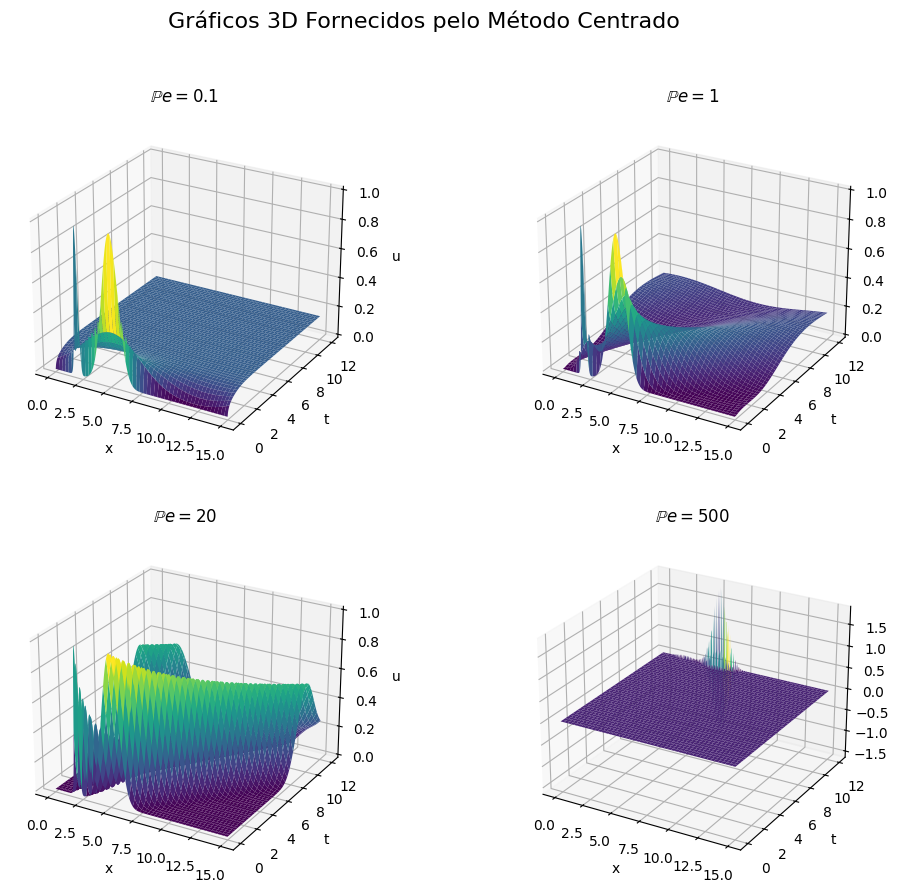

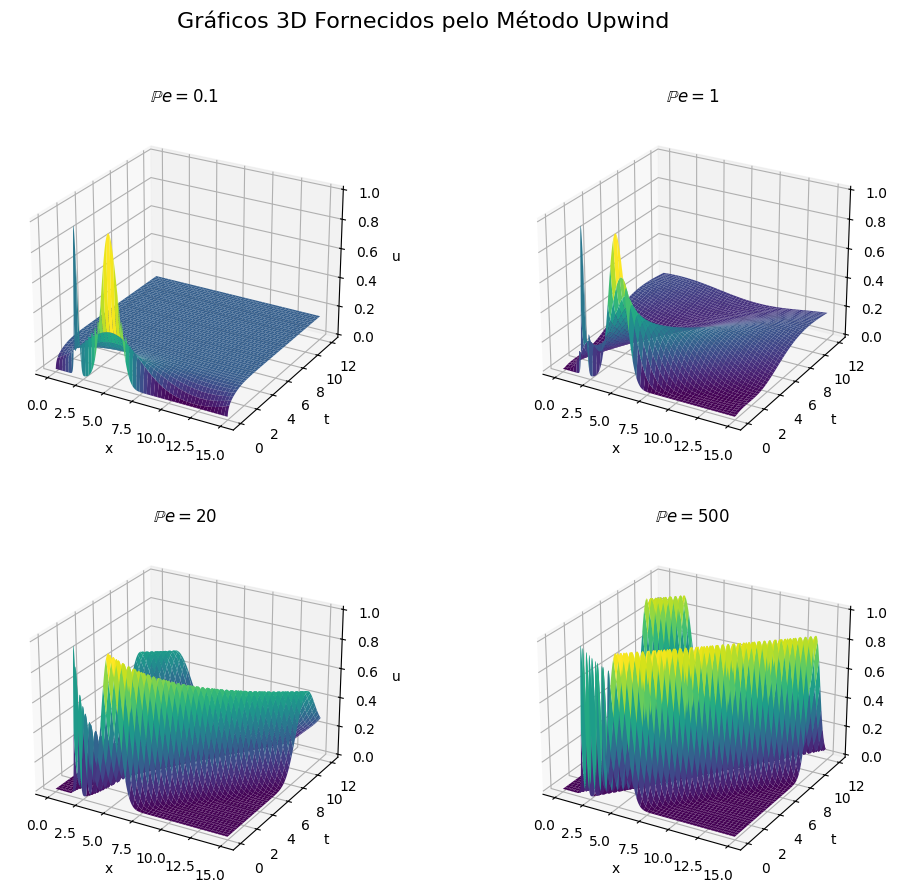

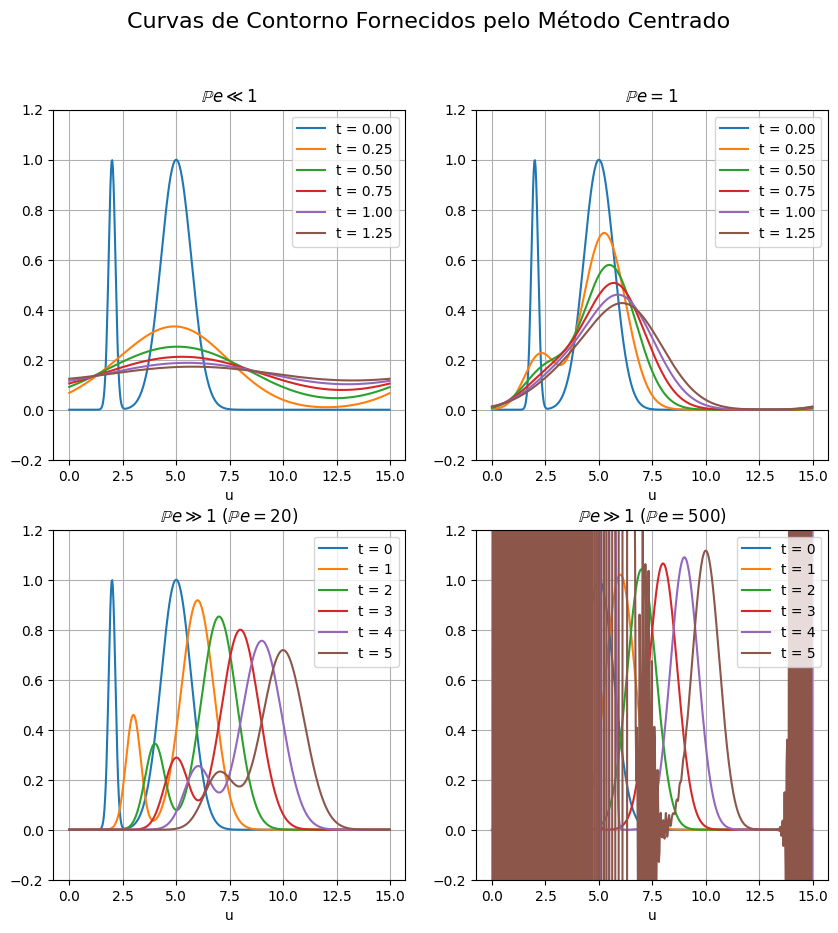

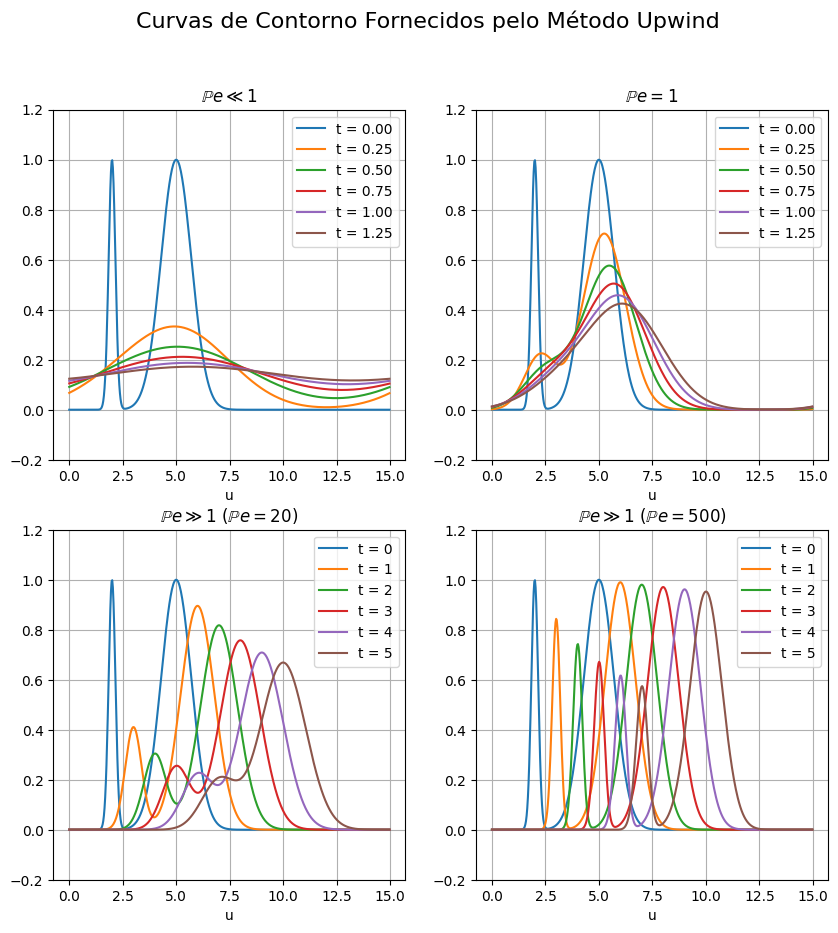

In [7]:
# Inicialização das figuras 3D para os métodos 'centrado' e 'upwind'
fig1_ftcs  , axes1_ftcs   = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})
fig1_upwind, axes1_upwind = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})

# Inicialização das curvas de contorno 2D para os métodos 'centrado' e 'upwind'
fig2_ftcs  , axes2_ftcs   = plt.subplots(2, 2, figsize=(10, 10))
fig2_upwind, axes2_upwind = plt.subplots(2, 2, figsize=(10, 10))

zipped_params = zip(
    peclet_numbers,
    axes1_ftcs.flatten(),
    axes1_upwind.flatten(),
    axes2_ftcs.flatten(),
    axes2_upwind.flatten(),
)

# Títulos das figuras 3D para os métodos 'centrado' e 'upwind'
fig1_ftcs.suptitle('Gráficos 3D Fornecidos pelo Método Centrado', fontsize=16)
fig1_upwind.suptitle('Gráficos 3D Fornecidos pelo Método Upwind', fontsize=16)

# Títulos das curvas de contorno 2D para os métodos 'centrado' e 'upwind'
fig2_ftcs.suptitle('Curvas de Contorno Fornecidos pelo Método Centrado', fontsize=16)
fig2_upwind.suptitle('Curvas de Contorno Fornecidos pelo Método Upwind', fontsize=16)

# Plot dos gráficos (sub-figuras)
for Pe, ax1_f, ax1_u, ax2_f, ax2_u in zipped_params:
    # Resolução Numérica da Eq. da Advecção-Difusão
    x_ftcs  , t_ftcs  , U_ftcs   = solve_advec_diff(Pe, dx, 'centered')
    x_upwind, t_upwind, U_upwind = solve_advec_diff(Pe, dx, 'upwind')

    # Geração dos gráficos 3D de cada método
    plot_3d(ax1_f  , x_ftcs  , t_ftcs  , U_ftcs  , Pe)
    plot_3d(ax1_u, x_upwind, t_upwind, U_upwind, Pe)

    # Geração dos gráficos 2D de cada método
    plot_2d(ax2_f  , x_ftcs  , t_ftcs  , U_ftcs  , Pe)
    plot_2d(ax2_u, x_upwind, t_upwind, U_upwind, Pe)

### 4 - Resolução da Tarefa 3 - Análise da Restrição para Estabilidade

In [8]:
Pe_values = np.logspace(-4, 4, 100)

dt_adv = np.full_like(Pe_values, dx)
dt_diff = (dx**2)/(2/Pe_values+dx)

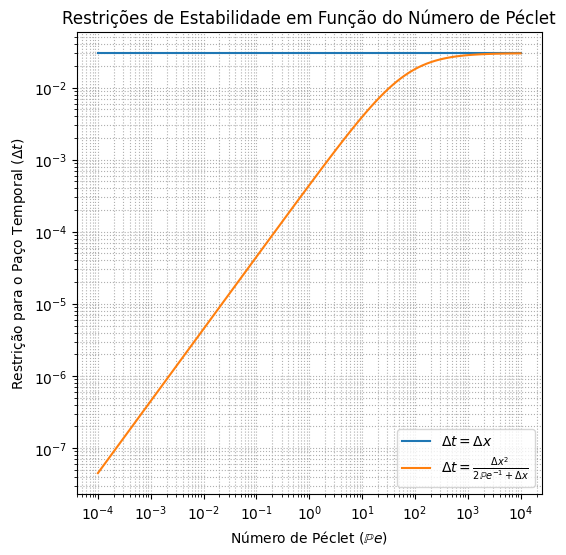

In [9]:
plt.figure(figsize=(6, 6))

plt.loglog(Pe_values, dt_adv, label=r'$\Delta t = \Delta x$')
plt.loglog(Pe_values, dt_diff, label=r'$\Delta t = \frac{\Delta x^2}{2{\mathbb{P}e}^{-1}+\Delta x}$')

plt.title('Restrições de Estabilidade em Função do Número de Péclet')
plt.xlabel(r'Número de Péclet ($\mathbb{P}e$)')
plt.ylabel(r'Restrição para o Paço Temporal ($\Delta t$)')
plt.legend()

plt.grid(True, which="both", ls=":")
plt.show()